# SIR model for COVID-19 reproducing the paper from Ma, 2022

In [1]:
import numpy as np
import matplotlib as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Classic SIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} =& - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} \tag{1}\\ \frac{{dI\left(t \right)}}{{dt}} =& \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \lambda I\left(t \right) \tag{2}\\ \frac{{dR\left(t \right)}}{{dt}} = & \lambda I\left(t \right) \tag{3} \end{align*}

### Extended SEIR model


\begin{align*} \frac{{dS\left(t \right)}}{{dt}} = & - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \alpha S\left(t \right) \tag{4}\\ \frac{{dE\left(t \right)}}{{dt}} = & \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \gamma E\left(t \right) \tag{5}\\ \frac{{dI\left(t \right)}}{{dt}} = & \gamma E\left(t \right) - \delta I\left(t \right) \tag{6}\\ \frac{{dQ\left(t \right)}}{{dt}} = & \delta I\left(t \right) - \lambda Q\left(t \right) - \kappa Q\left(t \right) \tag{7}\\ \frac{{dR\left(t \right)}}{{dt}} = & \lambda Q\left(t \right) \tag{8}\\ \frac{{dD\left(t \right)}}{{dt}} = & \kappa Q\left(t \right) \tag{9}\\ \frac{{dP\left(t \right)}}{{dt}} = & \alpha S\left(t \right) \tag{10} \end{align*}



### States of the SEIR model

- N: total number of people
- S: susceptible people
- E: exposed people
- I: infected people not quarantined
- Q: infected people quarantined
- P: protected people
- R: recovered people
- D: dead people

### Parameters of the SEIR model
- $\alpha$: protection rate
- $\beta$: infectious rate
- $\gamma^1$: average incubation
- $\delta^1$: average quarantine time
- $\lambda$: cure rate
- $\kappa$: mortality rate


In [2]:
# Define function for the system of differential equations
def seir_model(y, t, N, beta, alpha, gamma, delta, kappa, lam):
    S, E, I, Q, R, D, P = y
    dSdt = -beta*S*I/N - alpha*S
    dEdt = beta*S*I/N - gamma*E
    dIdt = gamma*E - delta*I
    dQdt = delta*I - lam*Q - kappa*Q
    dRdt = lam*Q
    dDdt = kappa*Q
    dPdt = alpha*S
    return dSdt, dEdt, dIdt, dQdt, dRdt, dDdt, dPdt

# Set initial conditions with values from the paper
N = 14000000
E0 = 318
I0 = 389
Q0 = 700
R0 = 0
D0 = 0
P0 = 0
S0 = N - E0 - I0 - Q0 - R0 - D0 - P0

#Set initial parameters with values from the paper
beta = 0.7      # infectious rate
alpha = 0.0185  # protection rate
gamma = 1/5     # gamma^(-1)=average incubation
delta = 1/7     # delta^(-1)=average quarantine time
kappa = 0.001   # mortality rate
lam = 0.1       # cure rate

# Set time discretization as in the paper
t = np.linspace(0, 180, 10000)

# Solve system of differential equations
# Returns the seven variables S, E, I, Q, R, D, and P at each time point
sol = odeint(seir_model, [S0, E0, I0, Q0, R0, D0, P0], t, args=(N, beta, alpha, gamma, delta, kappa, lam))


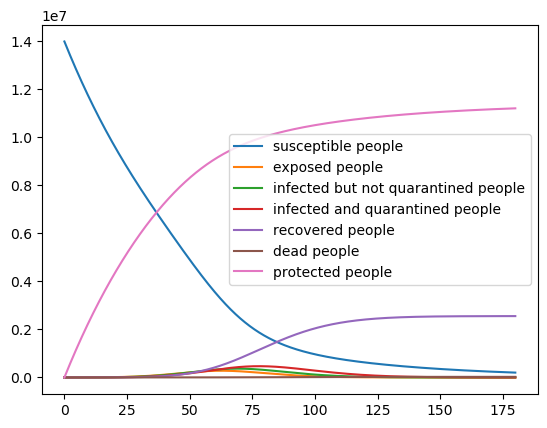

In [3]:
# Plot results

# dSdt, dEdt, dIdt, dQdt, dRdt, dDdt, dPdt
plt.plot(t,sol.T[0], label="susceptible people")
plt.plot(t,sol.T[1], label="exposed people")
plt.plot(t,sol.T[2], label="infected but not quarantined people")
plt.plot(t,sol.T[3], label="infected and quarantined people")
plt.plot(t,sol.T[4], label="recovered people")
plt.plot(t,sol.T[5], label="dead people")
plt.plot(t,sol.T[6], label="protected people")
plt.legend()

### Basic reproduction number

\begin{equation*} R0\ = \ \left({1 + \frac{{\ln (Y\left(t \right)/t)}}{\gamma }} \right)\left({1 + \frac{{\ln (Y\left(t \right)/t)}}{\lambda }} \right) \tag{11} \end{equation*}




In [4]:
# function to calculate R0 at a given time t
def calculate_R0(Y, t, gamma, lambd):
    return (1 + np.log(Y/t)/gamma) * (1 + np.log(Y/t)/lambd)


### Uncertainty quantification

In [5]:

from UQpy.run_model.RunModel import RunModel
from UQpy.run_model.model_execution.PythonModel import PythonModel
from UQpy.distributions import Uniform
from UQpy.distributions.collection.JointIndependent import JointIndependent
from UQpy.sensitivity.SobolSensitivity import SobolSensitivity
from UQpy.sensitivity.PostProcess import *


In [6]:
# Create Model object  

num_vars = 6

model = PythonModel(
    model_script="local_SEIR.py", # this file must be in the same folder
    model_object_name="solveSEIR", # this is the name of the main function called in local_SEIR.py
    var_names=["beta", #same order used when unpacking the parameters in solveSEIR
               "alpha",
               "gamma_inv",
               "delta_inv",
               "kappa",
               "lam"],
    delete_files=True #No idea what it means
)

runmodel_obj = RunModel(model=model)

# Define distribution object - for now I set a uniform distribution around the init values (don'tknow why 
# but in the other notebooks they put the greater value firtst in the range)
B= Uniform(0.7, (0.9 - 0.7))
A= Uniform(0.0185, (0.02 - 0.0185 ))
G_inv=Uniform(5, (7 - 5 ))
D_inv=Uniform(7, (7 - 5)) #
K=Uniform(0.002, (0.005 - 0.001 ))
L=Uniform(0.1, (0.2 - 0.1 ))

dist_object = JointIndependent([B, A, G_inv, D_inv, K, L])

In [8]:
%timeit
SA = SobolSensitivity(runmodel_obj, dist_object)
# Compute Sobol indices using the pick and freeze algorithm - for now low number of samples
SA.run(n_samples=2000, estimate_second_order=False)

In [8]:
SA.first_order_indices

array([[        nan, -0.00207691, -0.0020929 , ...,  0.15323965,
         0.15321932,  0.153199  ],
       [        nan, -0.00203294, -0.0020243 , ..., -0.00446303,
        -0.00446321, -0.00446339],
       [        nan,  0.88527646,  0.88574417, ...,  0.4440098 ,
         0.44394503,  0.44388025],
       [        nan,  0.1176628 ,  0.11714877, ...,  0.04252964,
         0.04253843,  0.04254721],
       [        nan, -0.00203295, -0.00202431, ..., -0.00212863,
        -0.00212957, -0.00213051],
       [        nan, -0.00203295, -0.00202431, ..., -0.00212863,
        -0.00212957, -0.00213051]])

In [9]:
#Capire perchè non funziona
np.shape(SA.first_order_confidence_interval)

()

### Plotting first order Sobol indices in time

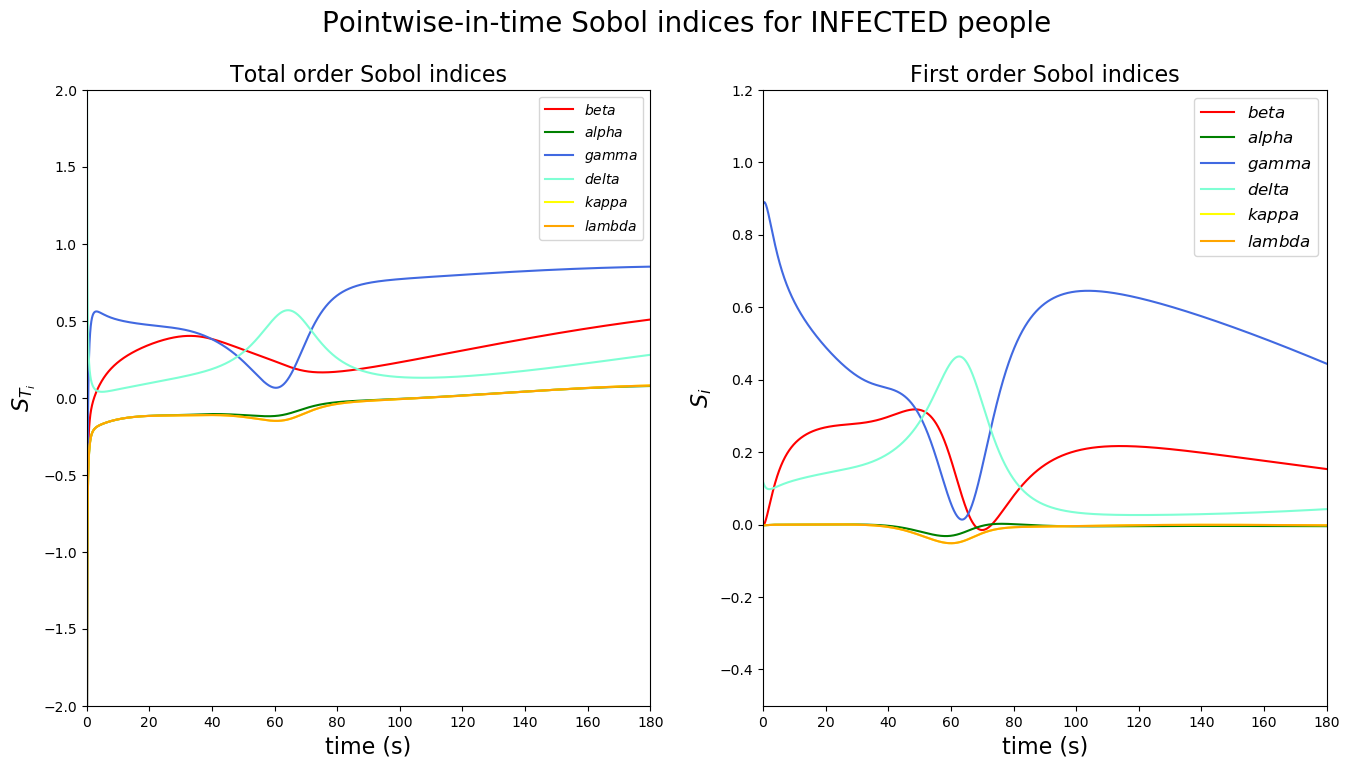

In [10]:

t_0 = 0
t_f = 180
n_t = 10000
T = np.linspace(t_0, t_f, n_t)


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].plot(T, SA.total_order_indices[0, :], "r" ,label=r"$beta$")
ax[0].plot(T, SA.total_order_indices[1, :], "g",label=r"$alpha$")
ax[0].plot(T, SA.total_order_indices[2, :], label=r"$gamma$", color="royalblue")
ax[0].plot(T, SA.total_order_indices[3, :], label=r"$delta$", color="aquamarine")
ax[0].plot(T, SA.total_order_indices[4, :], label=r"$kappa$", color="yellow")
ax[0].plot(T, SA.total_order_indices[5, :], label=r"$lambda$", color="orange")


ax[0].set_title("Total order Sobol indices", fontsize=16)
ax[0].set_xlabel("time (s)", fontsize=16)
ax[0].set_ylabel(r"$S_{T_i}$", fontsize=16)
ax[0].set_xbound(0, t_f)
ax[0].set_ybound(-2, 2)
ax[0].legend()

ax[1].plot(T, SA.first_order_indices[0, :], "r" ,label=r"$beta$")
ax[1].plot(T, SA.first_order_indices[1, :], "g",label=r"$alpha$")
ax[1].plot(T, SA.first_order_indices[2, :], label=r"$gamma$", color="royalblue")
ax[1].plot(T, SA.first_order_indices[3, :], label=r"$delta$", color="aquamarine")
ax[1].plot(T, SA.first_order_indices[4, :], label=r"$kappa$", color="yellow")
ax[1].plot(T, SA.first_order_indices[5, :], label=r"$lambda$", color="orange")


ax[1].set_title("First order Sobol indices", fontsize=16)
ax[1].set_xlabel("time (s)", fontsize=16)
ax[1].set_ylabel(r"$S_i$", fontsize=16)
ax[1].set_xbound(0, t_f)
ax[1].set_ybound(-0.5, 1.2)
ax[1].legend(fontsize=12)


##The order is still not clear
#ax[2].plot(T, SA.second_order_indices[0, :], "r" ,label=r"$beta$")
#ax[2].plot(T, SA.second_order_indices[1, :], "g",label=r"$alpha$")
#ax[2].plot(T, SA.second_order_indices[2, :], label=r"$gamma$", color="royalblue")
#ax[2].plot(T, SA.second_order_indices[3, :], label=r"$delta$", color="aquamarine")
#ax[2].plot(T, SA.second_order_indices[4, :], label=r"$kappa$", color="yellow")
#ax[2].plot(T, SA.second_order_indices[5, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[6, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[7, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[8, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[9, :], label=r"$lambda$", color="orange")
#ax[2].plot(T, SA.second_order_indices[10, :], label=r"$lambda$", color="orange")
#
#
#ax[2].set_title("Second order Sobol indices", fontsize=16)
#ax[2].set_xlabel("time (s)", fontsize=16)
#ax[2].set_ylabel(r"$S_i$", fontsize=16)
#ax[2].set_xbound(0, t_f)
#ax[2].set_ybound(-0.5, 1.2)
#ax[2].legend(fontsize=12)
#
fig.suptitle("Pointwise-in-time Sobol indices for INFECTED people", fontsize=20)

plt.show()

In [67]:
first_order_sobol_mean=np.array(np.zeros(5))
total_sobol_mean=np.array(np.zeros(5))

for i in range(5):
    first_order_sobol_mean[i]=np.mean(SA.first_order_indices[i, 1:])
    total_sobol_mean[i]=np.mean(SA.total_order_indices[i, 1:])


array([ 0.0700063 , -0.15810083,  0.60426248,  0.02952287, -0.17948456])